In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import metrics

In [2]:
movies = pd.read_pickle('movies.pkl')

#Replace missing values with actual Python NaN.
movies = movies.replace('N/A', np.NaN)
movies = movies.replace('NA', np.NaN)
movies = movies.replace('NULL', np.NaN)

#Set the imdbRating column as float instead of strings
movies.imdbRating = movies.imdbRating.astype(float)


In [3]:
#Makes a new Data Frame without movies with script missing.
movie_scripts = movies[(movies.script.notnull())].copy()
movie_scripts.reset_index(inplace = True)
del movie_scripts['index']

In [4]:
def sentiment(script, pages = 100, ma = 5):
    #Creates a moving average of the sentiment polarity of the script pages (or %)
    try:
        sentiment = []
        for i in range(pages+1):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+1)*len(script)/pages]).sentiment.polarity)
        MA = []
        for i in range(len(sentiment)-ma):
            MA.append(np.mean(sentiment[i:i+ma]))
        return MA
    except:
        return [0]
movie_scripts['sentiment'] = movies.script.apply(lambda x: sentiment(x))


In [5]:
movie_scripts['sentiment_avg'] = movie_scripts.sentiment.apply(lambda x: np.mean(x))
movie_scripts['sentiment_stdev'] = movie_scripts.sentiment.apply(lambda x: np.std(x))

In [6]:
#Remove rows where scripts were empity.
movie_scripts = movie_scripts[movie_scripts.sentiment_stdev != 0].copy()
del movie_scripts['level_0']
del movie_scripts['index']


KeyError: 'level_0'

In [7]:
import ast
#Select only the movies that were found with the IMDB API
movie_scripts = movie_scripts[movie_scripts.IMDB_info.apply(lambda x: ast.literal_eval(x['Response']))]


In [8]:
def awards(award):
    try:
        if 'Oscar' in award:
            return 1
        else:
            return 0
    except:
        return 0
movie_scripts.Awards = movie_scripts.Awards.apply(lambda x: awards(x)) 


C:\Anaconda2\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
print movie_scripts.apply(lambda x: np.sum(x.isnull()))
len(movie_scripts)

title                0
script               0
IMDB_info            0
Actors              13
imdbID               0
Awards               0
Country              2
Director            34
Genre                5
Language             4
Metascore          241
Plot                35
Rated               83
Released            27
Runtime             26
Writer              34
Year                 0
imdbRating          31
imdbVotes           31
financials           0
Budget             156
Revenue            176
sentiment            0
sentiment_avg        0
sentiment_stdev      0
dtype: int64


828

In [10]:
movie_scores = movie_scripts[['title','script','Actors','Awards','Director', 'Genre','Runtime', 'Writer','imdbRating', 'sentiment',  'sentiment_avg','sentiment_stdev']].copy()
movie_scores = movie_scores.dropna()
len(movie_scores)
movie_scores.reset_index(inplace = True, drop = True)
movie_scores.head()

,title,script,Actors,Awards,Director,Genre,Runtime,Writer,imdbRating,sentiment,sentiment_avg,sentiment_stdev
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",0,Gil Junger,"Comedy, Drama, Romance",97 min,"Karen McCullah, Kirsten Smith",7.2,"[0.11383952936, 0.105862606283, 0.081115874257...",0.050608,0.060887
1,12 and Holding,\n \n \n \n ...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",0,Michael Cuesta,Drama,94 min,Anthony Cipriano,7.6,"[0.0166268533054, -0.00886338353005, -0.051273...",0.012207,0.075825
2,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",1,Steve McQueen,"Biography, Drama, History",134 min,"John Ridley (screenplay), Solomon Northup (bas...",8.1,"[0.144452514765, 0.152337532525, 0.14795544635...",0.049629,0.064201
3,127 Hours,\n\r\n\r\n \r\n ...,"James Franco, Kate Mara, Amber Tamblyn, Sean Bott",1,Danny Boyle,"Adventure, Biography, Drama",94 min,"Danny Boyle (screenplay), Simon Beaufoy (scree...",7.6,"[-0.00192164832522, -0.00922014348086, -0.0075...",0.052450,0.061374
4,1492: Conquest of Paradise,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Gérard Depardieu, Armand Assante, Sigourney We...",0,Ridley Scott,"Adventure, Biography, Drama",154 min,Rose Bosch (scenario),6.5,"[0.133802253193, 0.121926184817, 0.08588619306...",0.040886,0.068049


In [11]:
class SentimentMetrics(TransformerMixin):
    def changes (self, sentiments):
        N_changes = 0
        for i in range(len(sentiments)-1):
            if sentiments[i]*sentiments[i+1] < 0:
                N_changes+=1
        return N_changes     
    
    def sentiment(self, script, pages = 100, ma = 5):
        #Creates a moving average of the sentiment polarity of the script pages (or %)
        sentiment = []
        for i in range(pages+1-ma):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+ma)*len(script)/pages]).sentiment.polarity)
        if np.std(sentiment) == 0:
            print sentiment
        return sentiment    
        
    def transform(self, X, **transform_params):
        if 'sentiment' in X:
            S = X.sentiment
        else:    
            S = X.script.apply(lambda x: SentimentMetrics.sentiment(self, x))
        sentiment_dic = {
       'Range': S.apply(lambda x: max(x) - min(x)),
       'Max_sentiment': S.apply(lambda x: max(x)),
       'Max_sentiment_loc': S.apply(lambda x: x.index(max(x))),
       'Min_sentiment': S.apply(lambda x: min(x)),
       'Min_sentiment_loc': S.apply(lambda x: x.index(min(x))),
       'Max_pos_change': S.apply(lambda x: pd.Series(x).diff(1).max()),
       'Max_pos_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).max())),
       'Max_neg_change': S.apply(lambda x: pd.Series(x).diff(1).min()),
       'Max_neg_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).min())),
       'Begin_sentiment': S.apply(lambda x: x[0]),
       'End_sentiment': S.apply(lambda x: x[-1]),
       'Total_change': S.apply(lambda x: x[-1] - x[0]),
       'plot_twist_index': S.apply(lambda x: (max(x[-10:]) - min(x[-10:]))/(max(x) - min(x) + 0.01) ),
       'pol_changes': S.apply(lambda x: SentimentMetrics.changes(self, x))
        }
            
        return pd.DataFrame(sentiment_dic).astype(float)
    
        
    
    def fit(self, X, y=None, **fit_params):
        return self      


In [12]:
class ScriptVectorizer(TransformerMixin):
    
    def __init__(self, transformer):
        self.transformer = transformer
        
    def transform(self, X, **transform_params):
        S = X.script
        vect = self.transformer
        return pd.DataFrame(vect.fit_transform(S).toarray(), columns = vect.get_feature_names())
    
    def fit(self, X, y=None, **fit_params):
        return self      

In [13]:
class ActorsVectorizer(TransformerMixin):
    
    def __init__(self, transformer):
        self.transformer = transformer
        
    def transform(self, X, **transform_params):
        S = X.Actors
        vect = self.transformer
        return pd.DataFrame(vect.fit_transform(S).toarray(), columns = vect.get_feature_names())
    
    def fit(self, X, y=None, **fit_params):
        return self  

In [36]:
a = ActorsVectorizer(CountVectorizer(ngram_range = (1,3)))
print a.fit_transform(movie_scores.head()).shape
b = ScriptVectorizer(TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=(1,3)))
print b.fit_transform(movie_scores.head()).shape
c = SentimentMetrics()
print c.fit_transform(movie_scores.head()).shape

fs = FeatureUnion([('sentiments', SentimentMetrics()),
                   ('actors', ActorsVectorizer(CountVectorizer(ngram_range = (1,3)))),
                   ('tfidf', ScriptVectorizer(TfidfVectorizer()))])
union = pd.DataFrame(fs.fit_transform(movie_scores))
union.head()

(5, 108)
(5, 11608)
(5, 14)


,0,1,2,3,4,5,6,7,8,9,...,117767,117768,117769,117770,117771,117772,117773,117774,117775,117776
0,0.113840,-0.105456,-0.103083,37.0,0.084757,29.0,0.197585,34.0,-0.118256,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016627,-0.078181,-0.140889,49.0,0.099050,44.0,0.247245,44.0,-0.106187,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.144453,-0.034591,-0.070908,52.0,0.073454,47.0,0.188489,5.0,-0.054840,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.001922,0.163705,-0.066765,66.0,0.056667,5.0,0.163705,95.0,-0.131344,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.133802,0.081928,-0.078153,43.0,0.095210,38.0,0.200317,42.0,-0.088939,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
union.shape

(764, 117777)

In [28]:
print union.shape
movie_scores.imdbRating.reshape((764,1)).shape

(5, 11730)


(764L, 1L)

In [30]:
pipe = Pipeline([('features', FeatureUnion([
                    ('sentiments', SentimentMetrics()),
                    ('actors', ActorsVectorizer(CountVectorizer(ngram_range = (1,3)))),
                    ('tfidf', ScriptVectorizer(TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=(1,3))))])),
                    ('linearReg', LinearRegression())])

In [32]:
mean =  cross_val_score(pipe, movie_scores[['Actors', 'script', 'sentiment']], movie_scores.imdbRating, cv=2, scoring='mean_absolute_error')



ValueError: shapes (382,146050) and (142075,) not aligned: 146050 (dim 1) != 142075 (dim 0)

In [89]:
pipe = Pipeline([('sentiments', SentimentMetrics()), ('linearReg', LinearRegression())])
mean = cross_val_score(pipe, movie_scores.script, movie_scores.imdbRating, cv=5, scoring='mean_absolute_error')



KeyboardInterrupt: 

In [26]:
mean

array([-0.78791341, -0.69280667, -0.77937522, -0.75381788, -0.67745607])

In [53]:
#null error
MAPE = np.absolute((movie_scores.imdbRating - movie_scores.imdbRating.mean())/movie_scores.imdbRating).mean()
RMSE = (np.sqrt((movie_scores.imdbRating - movie_scores.imdbRating.mean())**2)).mean()
print MAPE
print RMSE

0.114105394864
0.730756421151


In [54]:
X = movie_scores.script
y = movie_scores.imdbRating

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [15]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]

In [56]:
vect = TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [57]:
reg = LinearRegression()
reg.fit(X_train_dtm, y_train)
y_pred = reg.predict(X_test_dtm)

In [58]:
print metrics.mean_absolute_error(y_test, y_pred)

0.702330178237


In [35]:
#2.68546572034 CountVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)
#0.813613305902 TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)
#0.696885490284 no missing values

In [66]:
MAPE = np.absolute((movies.profit - movies.profit.mean())/movies.profit).mean()
RMSE = (np.sqrt((movies.profit - movies.profit.mean())**2)).mean()
print MAPE
print RMSE

17.2776104012
44509339.5365


In [64]:
y = movies.profit
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [67]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_dtm, y_train)
y_pred = reg.predict(X_test_dtm)

In [68]:
print metrics.mean_absolute_error(y_test, y_pred)

50822005.2416


In [61]:
B = (0.99/10000) + 0.01*9999/10000
(0.99/10000)*100/B

0.980392156862745

In [69]:
movies.head()

,title,script,Actors,Awards,Director,Genre,Runtime,Writer,imdbRating,Budget,Revenue,sentiment,sentiment_avg,sentiment_stdev,profit
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",0,Gil Junger,"Comedy, Drama, Romance",97 min,"Karen McCullah, Kirsten Smith",7.2,16000000.0,38176108.0,"[0.11383952936, 0.105862606283, 0.081115874257...",0.050608,0.060887,22176108.0
1,12,\n\n\n \n 12 - Script\n,"Sergey Makovetskiy, Nikita Mikhalkov, Sergey G...",1,Nikita Mikhalkov,"Crime, Drama, Thriller",159 min,"Nikita Mikhalkov, Aleksandr Novototskiy-Vlasov...",7.8,4000000.0,125024.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,-3874976.0
2,12 and Holding,\n \n \n \n ...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",0,Michael Cuesta,Drama,94 min,Anthony Cipriano,7.6,400000.0,95687.0,"[0.0166268533054, -0.00886338353005, -0.051273...",0.012207,0.075825,-304313.0
4,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",1,Steve McQueen,"Biography, Drama, History",134 min,"John Ridley (screenplay), Solomon Northup (bas...",8.1,20000000.0,56667870.0,"[0.144452514765, 0.152337532525, 0.14795544635...",0.049629,0.064201,36667870.0
5,127 Hours,\n\r\n\r\n \r\n ...,"James Franco, Kate Mara, Amber Tamblyn, Sean Bott",1,Danny Boyle,"Adventure, Biography, Drama",94 min,"Danny Boyle (screenplay), Simon Beaufoy (scree...",7.6,18000000.0,18329466.0,"[-0.00192164832522, -0.00922014348086, -0.0075...",0.052450,0.061374,329466.0


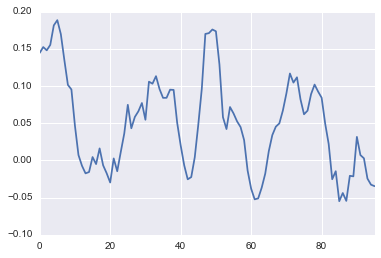

In [72]:
pd.Series(movies.sentiment[4]).plot()